In [1]:
# general imports
from datetime import date, datetime, timezone
import asyncio
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**General useful links**
* Community sourced [list](https://docs.google.com/spreadsheets/d/1ZEr3okdlb0zctmX0MZKo-gZKPsq5WGn1nJOxPV7al-Q/edit#gid=0) of useful APIs
* [Slides by Chris Bail on how to use APIs](https://sicss.io/2020/materials/day2-digital-trace-data/apis/Rpres/APIs.html#/52)

# Google Trends

Wrapper [documentation](https://pypi.org/project/pytrends/)

In [ ]:
# install python wrapper
! pip install pytrends

In [8]:
# import python wrapper
from pytrends.request import TrendReq

In [9]:
# initialize the client
trend_client = TrendReq()

In [ ]:
kw_list = ["Blockchain"] # list of keywords we want to get search trends for
timeframe = "today 5-y" # timeframe for which we want to request the trend
geo = "AT" # geographical scope for wich we want to request the trend

trend_client.build_payload(
    kw_list, 
    timeframe=timeframe,
    geo='AT'
)

In [ ]:
# the request directly returns a pandas DataFrame - very convenient!
df = trend_client.interest_over_time()
df.head(2)

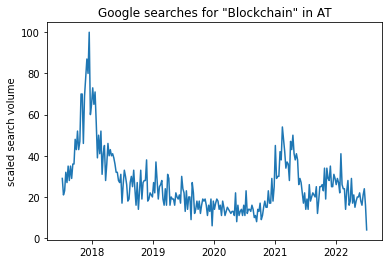

In [25]:
# visualize the result
fig, ax = plt.subplots()
kw = kw_list[0]
ax.plot(df.index, df[kw])
ax.set_ylabel("scaled search volume")
ax.set_title(f'Google searches for "{kw}" in {geo}');

# Telegram

Prerequisites: valid phone number, Telegram account & Telegram application  
Sign up for API access following this [guide](https://core.telegram.org/api/obtaining_api_id).

**Useful links**
* [Blog post](https://betterprogramming.pub/how-to-get-data-from-telegram-82af55268a4b) explaining how to get messages from a channel and corresponding [code repository](https://github.com/amiryousefi/telegram-analysis/blob/master/ChannelMessages.py). **Note**: the code in the blogpost is outdated and does not work anymore. Refer to the code in the repository, which is up-to-date.
* Wrapper [documentation](https://docs.telethon.dev/en/stable/)
* [Tool](https://telegramchannels.me/) to discover telegram channels.

In [ ]:
# install python wrapper
! pip install telethon
! pip install nest_asyncio

In [7]:
# the below code is necessary for asyncio to be able to run a 
# second event loop inside a JupyterNotebook.
import nest_asyncio
nest_asyncio.apply()

In [3]:
# import the wrapper
from telethon import TelegramClient
from telethon.errors import SessionPasswordNeededError
from telethon.tl.functions.messages import (GetHistoryRequest)
from telethon.tl.types import (
    PeerChannel
)

In [11]:
# function to parse a JSON date
class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime):
            return o.isoformat()

        if isinstance(o, bytes):
            return list(o)

        return json.JSONEncoder.default(self, o)

In [6]:
api_id = 1234 # your api ID goes here
api_hash = 'XXX' # your api hash goes here
phone = '+4367012345678' # your phone number goes here, including "+" and country code
username = 'Jana' # your Telegram username goes here

# create the client and connect
telclient = TelegramClient(username, api_id, api_hash)

In [54]:
async def main(phone):
    await client.start()
    print("Client Created")
    
    # ensure you're authorized: this will send a code to your phone and ask you
    # to enter it if you are not authorized yet
    if await client.is_user_authorized() == False:
        await client.send_code_request(phone)
        try:
            await client.sign_in(phone, input('Enter the code: '))
        except SessionPasswordNeededError:
            await client.sign_in(password=input('Password: '))

    me = await client.get_me()
    
    # enter a channel URL or ID, for example https://t.me/nytimes
    user_input_channel = input('enter entity(telegram URL or entity id):')

    if user_input_channel.isdigit():
        entity = PeerChannel(int(user_input_channel))
    else:
        entity = user_input_channel

    my_channel = await client.get_entity(entity)

    offset_id = 0
    limit = 100
    all_messages = []
    total_messages = 0
    total_count_limit = 0

    # get all messages from the given channel
    while True:
        print("Current Offset ID is:", offset_id, "; Total Messages:", total_messages)
        history = await client(GetHistoryRequest(
            peer=my_channel,
            offset_id=offset_id,
            offset_date=None,
            add_offset=0,
            limit=limit,
            max_id=0,
            min_id=0,
            hash=0
        ))
        if not history.messages:
            break
        messages = history.messages
        for message in messages:
            all_messages.append(message.to_dict())
        offset_id = messages[len(messages) - 1].id
        total_messages = len(all_messages)
        if total_count_limit != 0 and total_messages >= total_count_limit:
            break

    # save the messages to a JSON file
    with open('channel_messages.json', 'w') as outfile:
        json.dump(all_messages, outfile, cls=DateTimeEncoder)

async with client:
    client.loop.run_until_complete(main(phone))


In [55]:
# read the saved messages
with open("channel_messages.json", "r") as infile:
    content = infile.read()
    messages = json.loads(content)

In [ ]:
# inspect a single message
messages[0]

In [56]:
# parse the messages into a pandas data frame
df = pd.json_normalize(messages)
df.head(2)

,_,id,date,message,out,mentioned,media_unread,silent,post,from_scheduled,...,media.poll.close_period,media.poll.close_date,media.results._,media.results.min,media.results.results,media.results.total_voters,media.results.recent_voters,media.results.solution,media.results.solution_entities,action.title
0,Message,7141,2022-07-09T04:30:32+00:00,"We can't help everyone, but everyone can help ...",False,False,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Message,7140,2022-07-08T08:00:04+00:00,"You may be deceived if you trust too much, but...",False,False,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# YouTube Comments

**Note:** Didn't get it to work yet

Prerequisites: Google account  

**Useful links**
* Follow this [guide](https://www.geeksforgeeks.org/youtube-data-api-set-1/) to create your access credentials.
* The below code is part of this [tutorial](https://www.geeksforgeeks.org/how-to-extract-youtube-comments-using-youtube-api-python/) on downloading comments from videos.

In [ ]:
# install the wrapper
! pip install --upgrade google-api-python-client

In [10]:
# import the wrapper
from apiclient.discovery import build

In [11]:
# your API key goes here
api_key = "XXX" 

In [12]:
# create the YouTube API client
youtube_client = build('youtube', 'v3', developerKey=api_key)

In [ ]:
# copy the video ID from a YouTube search, for example 
# https://www.youtube.com/watch?v=iRXJXaLV0n4
video_id = "iRXJXaLV0n4"

# empty list for storing the replies
replies = []

# retrieve YouTube video comments
video_response=youtube_client.commentThreads().list(
part='snippet,replies',
videoId=video_id
).execute()

# iterate video response
while video_response:

    # extracting required info from each result object 
    for item in video_response['items']:
        # extracting comments
        comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
        # counting the number of reply of comment
        replycount = item['snippet']['totalReplyCount']
        # if there is a reply
        if replycount > 0:
            # iterate through all replies
            for reply in item['replies']['comments']:
                # extract the reply
                reply = reply['snippet']['textDisplay']
                replies.append(reply)

        replies = []

    # repeat for each batch of replies
    if 'nextPageToken' in video_response:
        video_response = youtube_client.commentThreads().list(
                part = 'snippet,replies',
                videoId = video_id
            ).execute()
    else:
        break

# New York Times

Follow [these](https://developer.nytimes.com/get-started) instructions to create a developer account and get an API key.  

**Useful links**
* API [Documentation](https://developer.nytimes.com/)
* Wrapper [Documentation](https://github.com/michadenheijer/pynytimes) of the `pynytimes` package.

In [3]:
# install python wrapper
! pip install pynytimes

  Using cached pynytimes-0.8.0-py3-none-any.whl (21 kB)


In [4]:
# import python wrapper
from pynytimes import NYTAPI

In [5]:
# initialize client - paste your key here
API_key = "G2tGIPRUksLfB4mfPeawbZCpgZk43inE"
client = NYTAPI(API_key, parse_dates=True)

In [7]:
# get the latest articles for a given query
articles = client.article_search(
    query = "Obama",
    results = 30,
    dates = {
        "begin": datetime(2019, 1, 31),
        "end": datetime(2019, 2, 28)
    },
    options = {
        "sort": "oldest",
        "sources": [
            "New York Times",
            "AP",
            "Reuters",
            "International Herald Tribune"
        ],
        "news_desk": [
            "Politics"
        ],
        "type_of_material": [
            "News Analysis"
        ]
    }
)

In [104]:
# convert the JSON into a pandas DataFrame
fields = ["abstract", "uri", "pub_date", "word_count", "document_type",
          "news_desk", "section_name", "subsection_name", "type_of_material"]
df = pd.DataFrame({field:[article[field] for article in articles] for field in fields})
df.head(2)

,abstract,uri,pub_date,word_count,document_type,news_desk,section_name,subsection_name,type_of_material
0,President Trump’s divisive behavior on race ha...,nyt://article/dc2ce387-1f03-5336-be0f-38da6275...,2019-02-04 01:02:16+00:00,1496,article,Politics,U.S.,Politics,News Analysis
1,"On one side of the debate, Bernie Sanders prom...",nyt://article/5fe4f5e9-8435-5d9c-bb3e-4fc0ea5c...,2019-02-20 10:00:08+00:00,1662,article,Politics,U.S.,Politics,News Analysis


# MediaWiki

## Basic access

Basic access to Wikipedia page content.

See also [this](https://pdf.co/blog/python-wikipedia-module-for-scraping-wikipedia-articles) page for other useful code snippets.

In [ ]:
# install Python API wrapper
! pip install wikipedia

In [105]:
# import Python API wrapper
import wikipedia

In [106]:
# search for page suggestions given a search term
search_term = "computational social science"
print(wikipedia.search(search_term))

['Computational social science', 'Computational science', 'Computational sociology', 'Theoretical computer science', 'Computational physics', 'Social computing', 'Computer science', 'Computational linguistics', 'Outline of computer science', 'Social science']


In [107]:
# suggest pages given a search term
search_term = "computational social scince"
print(wikipedia.suggest(search_term))

computational social science


In [108]:
# get the summary of a page given it's name
page_name = "computational social science"
print(wikipedia.summary(page_name))

Computational social science is the academic sub-discipline concerned with computational approaches to the social sciences. This means that computers are used to model, simulate, and analyze social phenomena. While large scale computational methods have been applied to natural sciences for decades, interest in applying data science to social sciences has grown significantly in the last decade. Fields include computational economics, computational sociology, cliodynamics, culturomics,  and the automated analysis of contents, in social and traditional media. It focuses on investigating social and behavioral relationships and interactions through social simulation, modeling, network analysis, and media analysis.




In [109]:
# retrieve a page object and iterate through all references on the page
page_name = "computational social science"
page = wikipedia.page(page_name)
references = page.links
 
for reference in references:
    print(reference)

Bibcode (identifier)
Big data
Cliodynamics
Computational cognition
Computational economics
Computational politics
Computational sociology
Computer simulation
Culturomics
Digital footprint
Digital humanities
Digital sociology
Doi (identifier)
Empirical research
European Social Simulation Association
Evolution Institute
Google Books
Google Ngram Viewer
Human Relations Area Files
ISBN (identifier)
ISSN (identifier)
Online content analysis
PMC (identifier)
PMID (identifier)
Peter N. Peregrine
Predictive analytics
Quantitative social research
S2CID (identifier)
Scientific method
Scientific theory
Seshat (project)
Social informatics
Social network analysis
Social science
Social simulation
Social web
University of Pittsburgh
Wayback Machine
Wiley Interdisciplinary Reviews: Computational Statistics


## Access for more serious scraping jobs

See also the [documentation](https://github.com/wikimedia/pywikibot) of the Python wrapper.

In [ ]:
# install Python wrapper for the API
! pip install pywikibot

In [ ]:
# install MediaWiki markup parser (used under the hood to parse content)
! pip install mwparserfromhell

In [110]:
# import Python wrapper
import pywikibot

In [111]:
# get all revisions for a given page and site
site = "wikipedia"
page_name = "computational social science"

# establish access to the site
site = pywikibot.Site("en", site) 

# establish access to the page on the site
page = pywikibot.Page(site, page_name) 

# create a generator object that iterates through all revisions of the given page
revisions = page.revisions(content=True) 
revs = [rev for rev in revisions] # get all revisions from the generator object

In [155]:
# inspect the earliest revision
revs[-1].values()

ValuesView(Revision({'revid': 565929711, 'parentid': 0, 'user': 'DaveDixon', 'userid': 1118943, 'timestamp': Timestamp(2013, 7, 26, 19, 52, 43), 'size': 217, 'sha1': '57bbeda8a90ee83c3bb64f5dcd32a06121fe0d8a', 'roles': ['main'], 'slots': {'main': {'contentmodel': 'wikitext', 'contentformat': 'text/x-wiki', '*': "'''Computational Social Science''' refers to the academic sub-disciplines concerned with computational approaches to the [[Social Science]]s. Fields include [[Computational Economics]] and [[Computational Sociology]]."}}, 'comment': 'Created the page', 'parsedcomment': 'Created the page', 'tags': [], 'anon': False, 'minor': False, 'userhidden': False, 'commenthidden': False, 'text': "'''Computational Social Science''' refers to the academic sub-disciplines concerned with computational approaches to the [[Social Science]]s. Fields include [[Computational Economics]] and [[Computational Sociology]].", 'contentmodel': 'wikitext'}))

In [156]:
# parse the JSON into a Pandas DataFrame

# fields of interest
fields = ["revid", "parentid", "user", "userid", "timestamp", "size", "comment"]
df = pd.DataFrame({field:[rev[field] for rev in revs] for field in fields})

# extract the revision text from the nested JSON
revtext = []
for rev in revs:
    try:
        revtext.append(rev["slots"]["main"]["*"])
    except KeyError:
        revtext.append(np.nan)
df["revision"] = revtext

# convert the datetime string to a datetime object, sort by earliest entry first
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp", ascending=True)

df.head(2)

,revid,parentid,user,userid,timestamp,size,comment,revision
96,565929711,0,DaveDixon,1118943,2013-07-26 19:52:43,217,Created the page,'''Computational Social Science''' refers to t...
95,565930062,565929711,DaveDixon,1118943,2013-07-26 19:55:43,280,Changed case,'''Computational social science''' refers to t...


# Steam ratings & comments

**Useful links**
* API [documentation](https://partner.steamgames.com/doc/store/getreviews)
* Wrapper [documentation](https://pypi.org/project/steamreviews/) of the `steamreviews` library.

In [ ]:
# install the Python wrapper for the Steam API
! pip install steamreviews

In [157]:
# import the Python wrapperand
import steamreviews

In [183]:
request_params = dict()
# Reference: https://partner.steamgames.com/doc/store/localization#supported_languages
request_params['language'] = 'english'
# Reference: https://partner.steamgames.com/doc/store/getreviews
request_params['review_type'] = 'positive'
request_params['purchase_type'] = 'steam'
# focus on reviews which were published during the past four weeks
request_params['day_range'] = '28'  

# search for the game you are interested in and get the app ID from the URL
# in the steam store. For example "GTA V":
# https://store.steampowered.com/agecheck/app/271590/
app_id = 271590

# get reviews for the given game
review_dict, query_count = steamreviews.download_reviews_for_app_id(
    app_id,
    chosen_request_params=request_params)

[appID = 271590] expected #reviews = 302764


In [ ]:
# inspect reviews
review_dict["reviews"]

In [185]:
# convert the (nested) JSON entries to a pandas DataFrame
df = pd.DataFrame()
df["id"] = list(review_dict["reviews"].keys())

author_fields = ["steamid", "num_games_owned", "num_reviews", "playtime_forever"]
for author_field in author_fields:
    df[f"author.{author_field}"] = \
        [review_dict["reviews"][ID]["author"][author_field] for ID in df["id"]]
    
review_fields = ["language", "review", "votes_up", "votes_funny", "comment_count"]
for review_field in review_fields:
    df[review_field] = [review_dict["reviews"][ID][review_field] for ID in df["id"]]
    
df.head(2)

,id,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,language,review,votes_up,votes_funny,comment_count
0,118467684,76561199199962489,2,1,187,english,Yes but get a good pc,0,0,0
1,118467472,76561199229476445,22,3,1112,english,noice,0,0,0


In [186]:
# inspect query summary
review_dict["query_summary"]

{'num_reviews': 100,
 'review_score': 6,
 'review_score_desc': 'Mostly Positive',
 'total_positive': 302764,
 'total_negative': 76285,
 'total_reviews': 302764}

Note that we only got 100 out of the promised 10k reviews. This is because the API returns a maximum of 100 reviews in one batch. To get the rest of the reviews, we need to iterate over batches using the "cursor":

In [187]:
# inspect query summary
review_dict["cursors"]

{'AoJw5pL2pIEDfqCnvQM=': 'Fri Jul  8 21:30:15 2022'}

In [195]:
# create a DataFrame with all current cursors to select the latest one

# parse cursors into a DataFrame
cursors = []
dates = []
for key, val in review_dict["cursors"].items():
    cursors.append(key)
    dates.append(val)
cursors = pd.DataFrame({"cursor":cursors, "date":dates})

# parse strings into datetime objects and sort by newest first
cursors["date"] = pd.to_datetime(cursors["date"])
cursors = cursors.sort_values(by="date", ascending=False)

# print most recent cursor
latest_cursor = cursors.iloc[0]["cursor"]
print(latest_cursor)

AoJw5pL2pIEDfqCnvQM=


In [196]:
# get the next batch of reviews
review_dict, query_count = steamreviews.download_reviews_for_app_id(
    app_id,
    chosen_request_params=request_params,
    start_cursor=latest_cursor
)

In [197]:
# now we have two cursors and a total of 200 reviews
review_dict["cursors"]

{'AoJw5pL2pIEDfqCnvQM=': 'Fri Jul  8 21:30:15 2022',
 'AoJ4xPCRo4EDdrOYvQM=': 'Fri Jul  8 21:33:12 2022'}

# OpenStreetMaps

**Useful links**
* API [documentation](https://wiki.openstreetmap.org/wiki/API)
* Helpful [code snippets](https://wiki.openstreetmap.org/wiki/OSMPythonTools).

Answer the question of whether Graz or Salzburg has more trees.

In [ ]:
# install the Python wrapper
! pip install OSMPythonTools

In [1]:
# get the area IDs for Graz and Salzburg using the nominatim API endpoint

# import and initialize the nominatim endpoint
from OSMPythonTools.nominatim import Nominatim
nominatim = Nominatim()

# get the area IDs
areaId_graz = nominatim.query('Graz, Austria').areaId()
areaId_salzburg = nominatim.query('Salzburg, Austria').areaId()

In [2]:
# get the tree counts for Graz and Salzburg using the overpass API endpoint

# import and initialize the overpass endpoint
from OSMPythonTools.overpass import Overpass
overpass = Overpass()

# build a query for Graz
from OSMPythonTools.overpass import overpassQueryBuilder
query_graz = overpassQueryBuilder(
    area=areaId_graz,
    elementType='node',
    selector='"natural"="tree"',
    out='count'
)

# query the API 
result_graz = overpass.query(query_graz)

In [3]:
# build a query for Salzburg
query_salzburg = overpassQueryBuilder(
    area=areaId_salzburg,
    elementType='node',
    selector='"natural"="tree"',
    out='count'
)

# query the API
result_salzburg = overpass.query(query_salzburg)

In [6]:
# count the number of trees for both cities given the query result
count_graz = result_graz.countElements()
count_salzburg = result_salzburg.countElements()

print(f"Trees in Graz: {count_graz}")
print(f"Trees in Salzburg: {count_salzburg}")

Trees in Graz: 8380
Trees in Salzburg: 3937


# Crossref

**Useful links**
* API [documentation](https://www.crossref.org/documentation/retrieve-metadata/rest-api/)
* Wrapper [documentation](https://pypi.org/project/crossrefapi/1.0.3/)
* Recent article: [Crossref as a source of open bibliographic metadata](https://osf.io/preprints/metaarxiv/smxe5/)

In [ ]:
# install the wrapper
! pip install crossrefapi

In [13]:
# import the wrapper
from crossref.restful import Works

In [14]:
# set up a client
works_client = Works()
# querying the client returns a generator
works = works_client.query('zika')

In [15]:
# iterate over the generator to store a list of works-items
works_list = []
for item in works:
    works_list.append(item)

In [17]:
# inspect a work
works_list[0]

{'indexed': {'date-parts': [[2022, 3, 30]],
  'date-time': '2022-03-30T01:40:28Z',
  'timestamp': 1648604428644},
 'reference-count': 0,
 'publisher': 'American Public Health Association',
 'content-domain': {'domain': [], 'crossmark-restriction': False},
 'published-print': {'date-parts': [[2020, 1]]},
 'DOI': '10.2105/ccdmc.3087.144',
 'type': 'book-chapter',
 'created': {'date-parts': [[2020, 8, 21]],
  'date-time': '2020-08-21T13:34:00Z',
  'timestamp': 1598016840000},
 'source': 'Crossref',
 'is-referenced-by-count': 1,
 'title': ['Zika'],
 'prefix': '10.2105',
 'author': [{'given': 'L.',
   'family': 'Yee-Sin',
   'sequence': 'first',
   'affiliation': []}],
 'member': '844',
 'published-online': {'date-parts': [[2020, 8, 21]]},
 'container-title': ['Control of Communicable Diseases Clinical Practice'],
 'deposited': {'date-parts': [[2020, 8, 21]],
  'date-time': '2020-08-21T13:34:27Z',
  'timestamp': 1598016867000},
 'score': 16.392893,
 'resource': {'primary': {'URL': 'https://

In [19]:
# convert to a pandas DataFrame
df = pd.json_normalize(works_list)
df.head(2)

,reference-count,publisher,DOI,type,source,is-referenced-by-count,title,prefix,author,member,...,relation.is-reply-to,event.sponsor,resource.secondary,event.number,relation.is-identical-to,relation.has-reply,relation.is-supplemented-by,chair,relation.has-comment,clinical-trial-number
0,0.0,American Public Health Association,10.2105/ccdmc.3087.144,book-chapter,Crossref,1.0,[Zika],10.2105,"[{'given': 'L.', 'family': 'Yee-Sin', 'sequenc...",844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,American Public Health Association,10.2105/ccdml.2868.145,book-chapter,Crossref,2.0,[Zika],10.2105,"[{'given': 'D. W.', 'family': 'Brown', 'sequen...",844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# OpenCitations

**Useful links**
* API [Documentation](https://opencitations.net/api/v1)  
* Wrapper [Documentation](https://pypi.org/project/opencitingpy/)

In [ ]:
# install the Pyhton API wrapper
! pip install opencitingpy

In [ ]:
# import the API wrapper
import opencitingpy

In [199]:
# initialize the API client
client = opencitingpy.client.Client()

# list of DOIs of articles we are interested in
dois = ['10.1038/s41586-021-03659-0',
        '10.1038/s41586-021-03660-7',
        '10.1038/s41586-021-03666-1',
        '10.1038/s41586-021-03694-x',
        '10.1038/s41586-021-03649-2'
       ]

# get metadata of a list of articles, including title, publication year, 
# number of citing and cited documents, etc.
metadata = client.get_metadata(dois)

In [ ]:
# inspect the results
for entry in metadata:
    print(f"author: {entry.title}")
    print(f"journal: {entry.source_title}")
    print(f"citations: {entry.citation_count}")
    print(f"open access link: {entry.oa_link}")
    print()

# Spotify

To get access credentials, create a Spotify account and go to the developer [dashboard](https://developer.spotify.com/dashboard). Create an app and copy the `client id`and `client secrret`below.

In [ ]:
client_id = "XXX"
client_secret = "XXX"

**Useful links**
* API [documentation](https://developer.spotify.com/documentation/web-api/)
* Wrapper [documentation](https://spotipy.readthedocs.io/en/master/)

In [ ]:
# install the wrapper
! pip install spotipy

In [1]:
# import the wrapper and the authentification module
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
# create a client and authenticate with your credentials
credentials = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)
spotify_client= spotipy.Spotify(client_credentials_manager=credentials)

In [4]:
# to analyze individual tracks, we first need to get track IDs. An easy way
# to do this is to first get a playlist ID and then iterate over all its tracks.
# Get a playlist ID by searching for something using Spotify's search. For 
# example a search for "metal" yields the "metal essentials" playlist
# https://open.spotify.com/playlist/37i9dQZF1DWWOaP4H0w5b0
playlist_uri = "spotify:playlist:37i9dQZF1DWWOaP4H0w5b0"

In [5]:
playlist = spotify_client.playlist_items(playlist_uri)

In [6]:
# this is how you get to the URI (uniform resource identifier) of an
# individual track
playlist["items"][0]["track"]["uri"]

'spotify:track:2MuWTIM3b0YEAskbeeFE1i'

In [18]:
# get the URIs of all tracks in the playlist
track_URIs = [entry["track"]["uri"] for entry in playlist["items"]]

In [20]:
# get the audio features for all tracks
tracks = []
for track_URI in track_URIs:
    track = spotify_client.audio_features(track_URI)
    tracks.extend(track)

In [22]:
# inspect the audio features of an individual track
tracks[0]

{'danceability': 0.543,
 'energy': 0.836,
 'key': 4,
 'loudness': -9.11,
 'mode': 0,
 'speechiness': 0.0353,
 'acousticness': 0.000647,
 'instrumentalness': 0.431,
 'liveness': 0.153,
 'valence': 0.56,
 'tempo': 105.173,
 'type': 'audio_features',
 'id': '2MuWTIM3b0YEAskbeeFE1i',
 'uri': 'spotify:track:2MuWTIM3b0YEAskbeeFE1i',
 'track_href': 'https://api.spotify.com/v1/tracks/2MuWTIM3b0YEAskbeeFE1i',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2MuWTIM3b0YEAskbeeFE1i',
 'duration_ms': 515387,
 'time_signature': 4}

In [27]:
# convert the audio features to a pandas DataFrame
df = pd.json_normalize(tracks)
df.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.543,0.836,4,-9.110,0,0.0353,0.000647,0.431000,0.153,0.560,105.173,audio_features,2MuWTIM3b0YEAskbeeFE1i,spotify:track:2MuWTIM3b0YEAskbeeFE1i,https://api.spotify.com/v1/tracks/2MuWTIM3b0YE...,https://api.spotify.com/v1/audio-analysis/2MuW...,515387,4
1,0.354,0.982,4,-3.026,0,0.1680,0.000237,0.000294,0.204,0.194,143.772,audio_features,61mWefnWQOLf90gepjOCb3,spotify:track:61mWefnWQOLf90gepjOCb3,https://api.spotify.com/v1/tracks/61mWefnWQOLf...,https://api.spotify.com/v1/audio-analysis/61mW...,252613,4


# Yahoo finance via Pandas datareader

**Useful links**
* An [index](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html) of data sources available through the data reader.

In [ ]:
# install the datareader
! pip install pandas-datareader

In [37]:
# import the data reader
from pandas_datareader import data, wb

In [41]:
# specify start date, end date and stock
start_date = pd.to_datetime("2020-01-01")
end_date = pd.to_datetime("2020-12-31")
stock = "TSLA"

# get the data
df = data.DataReader(stock, "yahoo", start_date, end_date)
df.head(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997


# StackOverflow

**Useful links**
* API [documentation](https://api.stackexchange.com/docs)
* Wrapper [documentation](https://stackapi.readthedocs.io/en/latest/user/intro.html)

In [ ]:
# install the wrapper
! pip install stackapi

In [43]:
# import the wrapper
from stackapi import StackAPI

In [44]:
# get the 500 most recent comments
SITE = StackAPI('stackoverflow')
comments = SITE.fetch('comments')

In [48]:
# inspect a comment
comments["items"][0]

{'owner': {'reputation': 482,
  'user_id': 18311567,
  'user_type': 'registered',
  'profile_image': 'https://i.stack.imgur.com/Kt0lV.jpg?s=256&g=1',
  'display_name': 'akaAbdullahMateen',
  'link': 'https://stackoverflow.com/users/18311567/akaabdullahmateen'},
 'edited': False,
 'score': 0,
 'creation_date': 1657322294,
 'post_id': 72917807,
 'comment_id': 128791092,
 'content_license': 'CC BY-SA 4.0'}

In [51]:
# convert parse JSON into a pandas DataFrame
df = pd.json_normalize(comments["items"])
df.head(2)

,edited,score,creation_date,post_id,comment_id,content_license,owner.reputation,owner.user_id,owner.user_type,owner.profile_image,owner.display_name,owner.link,owner.accept_rate,reply_to_user.reputation,reply_to_user.user_id,reply_to_user.user_type,reply_to_user.accept_rate,reply_to_user.profile_image,reply_to_user.display_name,reply_to_user.link
0,False,0,1657322294,72917807,128791092,CC BY-SA 4.0,482,18311567,registered,https://i.stack.imgur.com/Kt0lV.jpg?s=256&g=1,akaAbdullahMateen,https://stackoverflow.com/users/18311567/akaab...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,0,1657322288,72917736,128791091,CC BY-SA 4.0,129,11931524,registered,https://www.gravatar.com/avatar/9ebb6fc797fd74...,HEllRZA,https://stackoverflow.com/users/11931524/hellrza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Mastodon

See also [documentation](https://mastodonpy.readthedocs.io/en/stable/index.html).

In [ ]:
! pip3 install Mastodon.py

In [22]:
from mastodon import Mastodon

In [28]:
# note: create an application in your mastodon account to get an access token
mastodon = Mastodon(
    access_token="XXX",
    api_base_url="https://mastodon.social/"
)

In [31]:
result = mastodon.search("@janalasser")

MastodonNetworkError: Could not complete request: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [30]:
result

{'accounts': [{'id': 109257851215221327,
   'username': 'janalasser',
   'acct': 'janalasser',
   'display_name': 'Jana Lasser',
   'locked': False,
   'bot': False,
   'discoverable': True,
   'group': False,
   'created_at': datetime.datetime(2022, 10, 30, 0, 0, tzinfo=tzutc()),
   'note': '<p>PostDoc @tugraz | Computational Social Science, Data Science, complex systems,  comp. modelling | <a href="https://mastodon.social/tags/OpenScience" class="mention hashtag" rel="tag">#<span>OpenScience</span></a>, <a href="https://mastodon.social/tags/coder" class="mention hashtag" rel="tag">#<span>coder</span></a> | advisory board @N2PhDNet | she/her</p>',
   'url': 'https://mastodon.social/@janalasser',
   'uri': 'https://mastodon.social/users/janalasser',
   'avatar': 'https://files.mastodon.social/accounts/avatars/109/257/851/215/221/327/original/f6e0a5b75861e76a.png',
   'avatar_static': 'https://files.mastodon.social/accounts/avatars/109/257/851/215/221/327/original/f6e0a5b75861e76a.png',

# TODO

## GitHub

**Note:** Didn't get it to work yet

* API [usage example](https://melaniesoek0120.medium.com/how-to-use-github-api-to-extract-data-with-python-bdc61106a501)

## VK

# Deprecated

## Twitter v2 API

**Useful links**  
* API [Documentation](https://developer.twitter.com/en/docs/twitter-api)  
* Wrapper `twarc` [Documentation](https://twarc-project.readthedocs.io/en/latest/api/client2/)
* Alternative wrapper `tweepy` [Documentation](https://www.tweepy.org/)  
* Sample [code snippets](https://github.com/twitterdev/Twitter-API-v2-sample-code)  
* Developer [forum](https://twittercommunity.com/)

In [ ]:
# install the python wrapper
! pip install twarc

In [19]:
# import the python wrapper
from twarc import Twarc2

In [27]:
# authentification
bearer_token = "XXX" # replace the XXX with your bearer token
twarc_client = Twarc2(bearer_token=bearer_token)

### Search endpoint

Search Twitter for tweets containing the search string in the specified time window and store all the results in the list.

In [28]:
# empty list to store the search results
tweets = [] 

# tweets we look for should contain the following search string
query = '#SICSS'

# start and end time of the query
start = datetime(2022, 7, 1, 0, 0, 0, 0, tzinfo=timezone.utc)
end = datetime(2022, 7, 5, 0, 0, 0, 0, tzinfo=timezone.utc)

# Note: if you only have "essential" or "elevated" API access, you have to use
# the function search_recent() and can only access tweets from the last 7 days.
# If you have "academic" access, you can use the search_all() function as in the
# example to access historic tweets back to march 2010 when Twitter was founded.
for tweet in twarc_client.search_all(
        query,
        start_time=start,
        end_time=end):
    tweets.append(tweet)

In [29]:
# inspecting a single tweet object
tweets[0]["data"][0]

{'reply_settings': 'everyone',
 'conversation_id': '1544068730291888130',
 'lang': 'en',
 'entities': {'mentions': [{'start': 3,
    'end': 15,
    'username': 'ruettenauer',
    'id': '397991469'}]},
 'referenced_tweets': [{'type': 'retweeted', 'id': '1407011287717060610'}],
 'text': 'RT @ruettenauer: In case you are interested in a short introduction to geospatial data and analysis 🌍🧐, have a look at the course materials…',
 'possibly_sensitive': False,
 'author_id': '1550709612',
 'public_metrics': {'retweet_count': 24,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'created_at': '2022-07-04T21:20:47.000Z',
 'id': '1544068730291888130',
 'source': 'Twitter for Android'}

In [38]:
# converting the JSON entries to a pandas DataFrame
df = pd.json_normalize(tweets, record_path=['data'])
df.head(2)

,reply_settings,conversation_id,lang,referenced_tweets,text,possibly_sensitive,author_id,created_at,id,source,...,in_reply_to_user.protected,in_reply_to_user.profile_image_url,author.entities.description.hashtags,author.entities.description.mentions,context_annotations,entities.urls,entities.annotations,attachments.media_keys,attachments.media,in_reply_to_user.entities.url.urls
0,everyone,1544068730291888130,en,"[{'type': 'retweeted', 'id': '1407011287717060...",RT @ruettenauer: In case you are interested in...,False,1550709612,2022-07-04T21:20:47.000Z,1544068730291888130,Twitter for Android,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,everyone,1544060779397349383,pt,"[{'type': 'replied_to', 'id': '154406077939734...",Parabéns a toda equipe que organizou esse fant...,False,787115307756359680,2022-07-04T20:49:12.000Z,1544060782488559620,Twitter Web App,...,False,https://pbs.twimg.com/profile_images/142552424...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Counts endpoint

In [70]:
# if you don't have academic level access, use counts_recent() to access tweet
# counts for the last 7 days

query = '#SICSS'
start = datetime(2021, 1, 1, 0, 0, 0, 0, tzinfo=timezone.utc)
end = datetime(2022, 7, 5, 0, 0, 0, 0, tzinfo=timezone.utc)

day_counts = []
for c in twarc_client.counts_all(
    query, 
    start_time=start, 
    end_time=end, 
    granularity='day'):
    
    day_counts.extend(c['data'])

In [71]:
# inspecting a single count
day_counts[0]

{'end': '2022-06-05T00:00:00.000Z',
 'start': '2022-06-04T00:00:00.000Z',
 'tweet_count': 0}

In [72]:
# saving the JSON to a file
with open("counts.json", "w") as counts_file:
    json_object = json.dumps(day_counts)
    counts_file.write(json_object)

In [73]:
# reading the JSON file into a pandas DataFrame
df = pd.read_json("counts.json")
df.head(2)

,end,start,tweet_count
0,2022-06-05T00:00:00.000Z,2022-06-04T00:00:00.000Z,0
1,2022-06-06T00:00:00.000Z,2022-06-05T00:00:00.000Z,0


In [75]:
# converting the start and end time into a datetime object
df["start"] = pd.to_datetime(df["start"])
df["end"] = pd.to_datetime(df["end"])
df.head(2)

,end,start,tweet_count
0,2022-06-05 00:00:00+00:00,2022-06-04 00:00:00+00:00,0
1,2022-06-06 00:00:00+00:00,2022-06-05 00:00:00+00:00,0


In [77]:
# sort counts by start date
df = df.sort_values(by="start", ascending=True)

Text(0.5, 1.0, 'tweets with #SICSS')

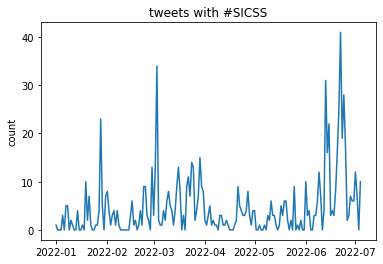

In [79]:
# visualize results
fig, ax = plt.subplots()
ax.plot(df["start"], df["tweet_count"])
ax.set_ylabel("count")
ax.set_title("tweets with #SICSS")

## Twitter v2 API with tweepy

In [ ]:
! pip install tweepy

In [74]:
import tweepy
client = tweepy.Client(bearer_token="XXX")

In [75]:
IDs = ['1503551557735833603', '1503551557731770369',
       '1503551557769445376', '1503551557735960581',
       '1503551557757181953', '1503551557744291841',
       '1503551557769601025', '1503551557765562368',
       '1503551557740150785', '1503551557753016322']

In [77]:
tweets = client.get_tweets(IDs, tweet_fields=["public_metrics"])

In [88]:
tweets.data[0].public_metrics

{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}

## PushShift: Reddit

No API key or signup needed.

**Useful links**
* PushShift new user [FAQ](https://www.reddit.com/r/pushshift/comments/bcxguf/new_to_pushshift_read_this_faq/).
* Useful [code snippets](https://melaniewalsh.github.io/Intro-Cultural-Analytics/04-Data-Collection/14-Reddit-Data.html).
* [Information](https://www.reddit.com/r/pushshift/comments/8ewz4o/pushshift_rate_limit_info/) on the PushShift API rate limits.

In [ ]:
# install the python wrapper
! pip install psaw 

In [80]:
# import the python wrapper
from psaw import PushshiftAPI

In [81]:
# intitialize the API
api = PushshiftAPI()

In [82]:
# get some data from the API

# note: casting the timestamps to int is necessary for the call to work
start = int(datetime(2021, 6, 1).timestamp()) 
end = int(datetime(2021, 7, 1).timestamp()) 
subreddit = "AmITheAsshole" 
filters = ['id', 'author', 'created_utc', 'domain', 'url',
           'title', 'num_comments', 'selftext'] 
limit = 10

posts = list(api.search_submissions(
    subreddit=subreddit,   # subreddit we want to get data from
    after=start,           # start date
    before=end,            # end date
    filter=filters,        # column names we want to retrieve
    limit=limit            # max number of posts
))          

In [83]:
# inspect a post object
posts[0]

submission(author='Outside-Question-191', created_utc=1625090218, domain='self.AmItheAsshole', id='ob7l42', num_comments=2, selftext='\nA lot of people enjoy anime, and I’m not going to judge someone based off of their interests. But, for some odd reason I have what can only be explained as an intense phobia of anime. This is not a joke and it’s really affecting me because whenever I go onto social media I always see Memes, photos or videos of those anime people. Whenever I see those animes I get this feeling in my chest like I’m going to have a heart attack,It becomes extremely difficult to breathe, I start shaking uncontrollably, and I start crying most times. I really don’t know why this is happening to me. A lot of my friends like anime’s , so I have to put up with them talking about it all the time it’s scaring me. One time I was trying to fit in with them when they were talking about their favorite animes, I told them my favorite anime was SpongeBob. I don’t understand what’s wro

In [88]:
# convert the posts to a pandas DataFrame
df = pd.DataFrame({
    "id":[post.id for post in posts],
    "author":[post.author for post in posts],
    "created_utc":[post.created_utc for post in posts],
    "domain":[post.domain for post in posts],
    "url":[post.url for post in posts],
    "title":[post.title for post in posts],
    "num_comments":[post.num_comments for post in posts],
    "selftext":[post.selftext for post in posts]
    })
df.head(2)

,id,author,created_utc,domain,url,title,num_comments,selftext
0,ob7l42,Outside-Question-191,1625090218,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,AITA for being scared of anime?,2,"\nA lot of people enjoy anime, and I’m not goi..."
1,ob7km0,Outside-Question-191,1625090175,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,Am I wrong for hating anime?,2,[removed]
